<a href="https://colab.research.google.com/github/shihanxie/Econ475/blob/main/Evaluating_and_Combining_Forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell as the first step to make sure we use the most updated version of statsmodels in python
# If it fails to import the latest version, try click Runtime -> Restart runtime and start from here again
!pip install statsmodels==0.12.0
import statsmodels

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

## OverSea Shipping Volumn
- OverSea Services is a major international cargo shipper
- To help guide fleet allocation decisions, each week it makes forecasts of volume shipped over each of its major trade lanes at various horizons ranging from 1 week ahead through 16 weeks ahead
- Actually, it produces two sets of forecasts: a quantitative forecast ```VPLQ``` and a judgmental forecast ```VOLJ```
- Here we will examine the actual volume and 2-week-ahead forecasts on volume on the Atlantic East trade lane (North America to Europe)

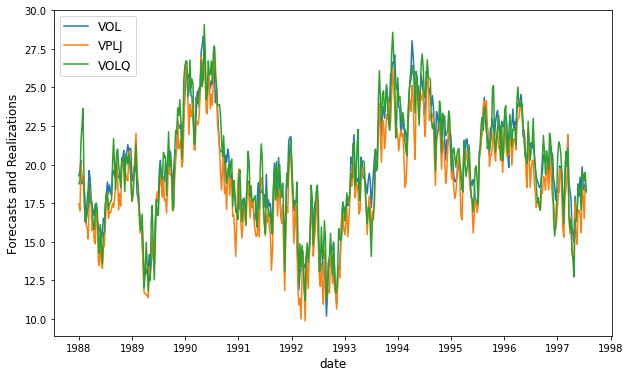

In [ ]:
shipping = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/OverSea.csv', 
                     na_values = '.', dtype={'VOL': np.float, 'VOLJ': np.float, 'VOLQ': np.float}, index_col='Date')
shipping.index = pd.to_datetime(shipping.index)

plt.figure(figsize=(10,6))
plt.plot(shipping[['VOL','VOLJ','VOLQ']])
ax = plt.gca()
ax.set_ylabel('Forecasts and Realizations', fontsize = 'large')
ax.set_xlabel('date', fontsize = 'large')
ax.legend(['VOL','VPLJ','VOLQ'], loc='upper left', fontsize = 'large')
plt.show()

## Quantitative forecast error

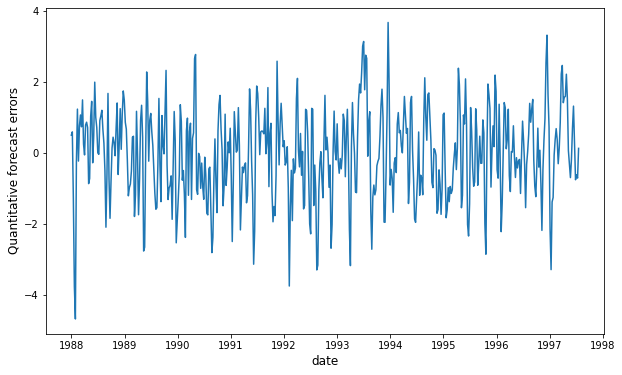

In [ ]:
shipping['Q_error'] = shipping['VOL'] - shipping['VOLQ']

plt.figure(figsize=(10,6))
plt.plot(shipping['Q_error'])
ax = plt.gca()
ax.set_ylabel('Quantitative forecast errors', fontsize = 'large')
ax.set_xlabel('date', fontsize = 'large')
plt.show()

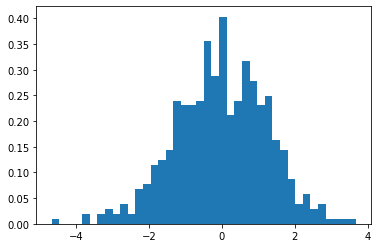

count    499.000000
mean      -0.026572
std        1.262817
min       -4.663387
25%       -0.884550
50%        0.002625
75%        0.870257
max        3.681641
Name: Q_error, dtype: float64
Skewness:  -0.20070612464793083
Kurtosis:  3.1940261225064095


In [ ]:
_,bins,_ = plt.hist(shipping['Q_error'],density = 1, bins=40)
plt.show()
print(shipping['Q_error'].describe())
print('Skewness: ', shipping['Q_error'].skew())
print('Kurtosis: ', stats.kurtosis(shipping['Q_error'], fisher = False))

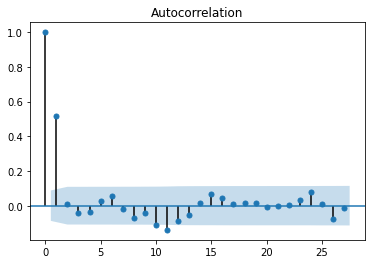

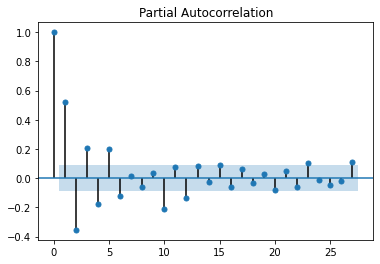

In [ ]:
plot_acf(shipping['Q_error'])
plot_pacf(shipping['Q_error'])
plt.show()

In [ ]:
result_qma1 = ARIMA(shipping['Q_error'], order=(0,0,1)).fit()
print(result_qma1.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                Q_error   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -667.532
Date:                Sat, 24 Apr 2021   AIC                           1341.064
Time:                        21:28:22   BIC                           1353.702
Sample:                    01-01-1988   HQIC                          1346.023
                         - 07-18-1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0265      0.081     -0.329      0.742      -0.184       0.131
ma.L1          0.9337      0.016     56.604      0.000       0.901       0.966
sigma2         0.8466      0.051     16.710      0.0

#### Mincer-Zarnowitz regression on the quantitative forecast

In [ ]:
result_MZ_q = ARIMA(shipping['VOL'], order=(0,0,1), exog=shipping['VOLQ']).fit()
print(result_MZ_q.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    VOL   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -629.948
Date:                Sat, 24 Apr 2021   AIC                           1267.896
Time:                        21:33:04   BIC                           1284.747
Sample:                    01-01-1988   HQIC                          1274.509
                         - 07-18-1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9801      0.354      8.413      0.000       2.286       3.674
VOLQ           0.8484      0.017     49.279      0.000       0.815       0.882
ma.L1          0.9096      0.018     49.776      0.0

####Wald tests Null hypothesis: the intercept = 0 and the coefficient on VOLQ = 1

In [ ]:
wald_q = result_MZ_q.wald_test('const=0, VOLQ=1')
print(wald_q.summary())

<Wald test (chi2): statistic=[[78.40957185]], p-value=9.409743999554828e-18, df_denom=2>


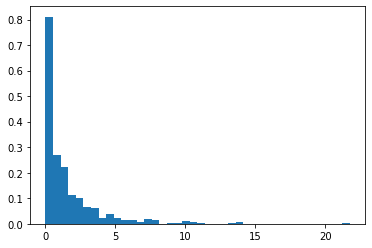

count    499.000000
mean       1.592217
std        2.369751
min        0.000006
25%        0.163721
50%        0.763750
75%        2.001678
max       21.747175
Name: Q_error2, dtype: float64
Skewness:  3.306567919481977
Kurtosis:  18.91870181385998


In [ ]:
shipping['Q_error2'] = shipping['Q_error']**2

_,bins,_ = plt.hist(shipping['Q_error2'],density = 1, bins=40)
plt.show()
print(shipping['Q_error2'].describe())
print('Skewness: ', shipping['Q_error2'].skew())
print('Kurtosis: ', stats.kurtosis(shipping['Q_error2'], fisher = False))

## Judgemental forecast error

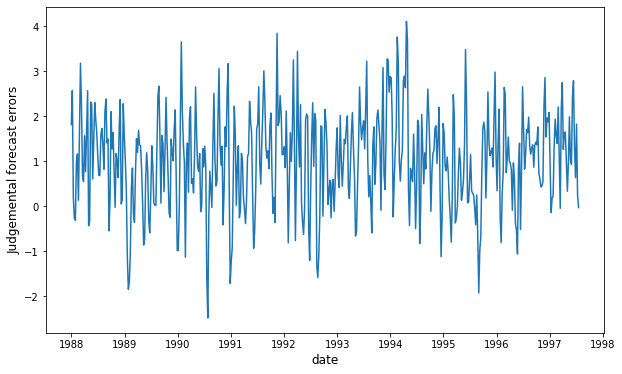

In [ ]:
shipping['J_error'] = shipping['VOL'] - shipping['VOLJ']

plt.figure(figsize=(10,6))
plt.plot(shipping['J_error'])
ax = plt.gca()
ax.set_ylabel('Judgemental forecast errors', fontsize = 'large')
ax.set_xlabel('date', fontsize = 'large')
plt.show()

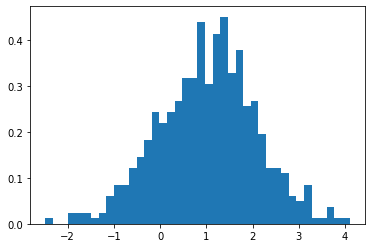

count    499.000000
mean       1.023744
std        1.063681
min       -2.481030
25%        0.323506
50%        1.060523
75%        1.735897
max        4.100623
Name: J_error, dtype: float64
Skewness:  -0.10657543813819859
Kurtosis:  3.084862143094086


In [ ]:
_,bins,_ = plt.hist(shipping['J_error'],density = 1, bins=40)
plt.show()
print(shipping['J_error'].describe())
print('Skewness: ', shipping['J_error'].skew())
print('Kurtosis: ', stats.kurtosis(shipping['J_error'], fisher = False))

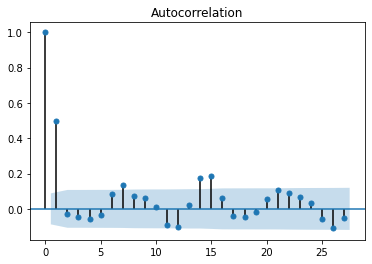

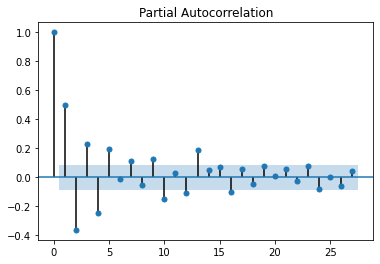

In [ ]:
plot_acf(shipping['J_error'])
plot_pacf(shipping['J_error'])
plt.show()

In [ ]:
result_jma1 = ARIMA(shipping['J_error'], order=(0,0,1)).fit()
print(result_jma1.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                J_error   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -575.511
Date:                Sat, 24 Apr 2021   AIC                           1157.023
Time:                        21:29:04   BIC                           1169.661
Sample:                    01-01-1988   HQIC                          1161.982
                         - 07-18-1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0229      0.067     15.205      0.000       0.891       1.155
ma.L1          0.9597      0.013     74.839      0.000       0.935       0.985
sigma2         0.5849      0.040     14.614      0.0

#### Mincer-Zarnowitz regression on the judgemental forecast

In [ ]:
result_MZ_j = ARIMA(shipping['VOL'], order=(0,0,1), exog=shipping['VOLJ']).fit()
print(result_MZ_j.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    VOL   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -557.919
Date:                Sat, 24 Apr 2021   AIC                           1123.837
Time:                        21:41:44   BIC                           1140.687
Sample:                    01-01-1988   HQIC                          1130.450
                         - 07-18-1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6380      0.277      9.532      0.000       2.096       3.180
VOLJ           0.9140      0.014     65.354      0.000       0.887       0.941
ma.L1          0.9453      0.016     60.361      0.0

#### Wald tests Null hypothesis: the intercept = 0 and the coefficient on VOLJ = 1


In [ ]:
wald_j = result_MZ_j.wald_test('const=0, VOLJ=1')
print(wald_j.summary())

<Wald test (chi2): statistic=[[271.18010806]], p-value=1.300132857349161e-59, df_denom=2>


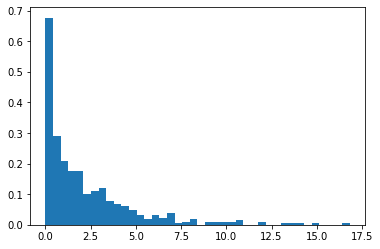

count    499.000000
mean       2.177201
std        2.623644
min        0.000046
25%        0.307693
50%        1.308296
75%        3.065333
max       16.815106
Name: J_error2, dtype: float64
Skewness:  2.1431404301219303
Kurtosis:  8.664110868911209


In [ ]:
shipping['J_error2'] = shipping['J_error']**2

_,bins,_ = plt.hist(shipping['J_error2'],density = 1, bins=40)
plt.show()
print(shipping['J_error2'].describe())
print('Skewness: ', shipping['J_error2'].skew())
print('Kurtosis: ', stats.kurtosis(shipping['J_error2'], fisher = False))

## Combining regression

In [ ]:
result_combine = ARIMA(shipping['VOL'], order=(0,0,1), exog=shipping[['VOLJ','VOLQ']]).fit()
print(result_combine.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    VOL   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -530.280
Date:                Sat, 24 Apr 2021   AIC                           1070.560
Time:                        21:46:17   BIC                           1091.623
Sample:                    01-01-1988   HQIC                          1078.826
                         - 07-18-1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2123      0.268      8.247      0.000       1.687       2.738
VOLJ           0.6281      0.037     17.012      0.000       0.556       0.700
VOLQ           0.2922      0.035      8.238      0.0